# Common
## Imports

In [1]:
from platform import python_version

print(python_version())

3.7.6


In [2]:
import hiive.mdptoolbox as mdptoolbox
import hiive.mdptoolbox.example
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from IPython.display import clear_output, display

# suppress pandas warning
pd.options.mode.chained_assignment = None

# set seed
np.random.seed(0)

%matplotlib inline

# Helper Functions

In [3]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail


# Setup Problem

In [4]:
T,R = hiive.mdptoolbox.example.forest(S=500)

# Value Iteration
## Function

In [5]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, time, iters, maxR))
            
            testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']
    
    ''' TODO - how to evaluate performance?
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    
    '''
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [54]:
gammas   = [0.1, 0.3, 0.6, 0.9, 0.99999999999]
epsilons = [1e-2, 1e-3, 1e-8, 1e-12]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

#vi_data.head()

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.10,	1E-02,	0.00,	2,	4.360000
0.10,	1E-03,	0.00,	3,	4.393300
0.10,	1E-08,	0.00,	8,	4.396613
0.10,	1E-12,	0.00,	12,	4.396613
0.30,	1E-02,	0.00,	4,	5.460862
0.30,	1E-03,	0.00,	6,	5.489575
0.30,	1E-08,	0.00,	15,	5.491933
0.30,	1E-12,	0.00,	22,	5.491933
0.60,	1E-02,	0.00,	11,	8.797055
0.60,	1E-03,	0.01,	15,	8.808703
0.60,	1E-08,	0.01,	33,	8.809994
0.60,	1E-12,	0.01,	48,	8.809994
0.90,	1E-02,	0.02,	39,	23.089675
0.90,	1E-03,	0.02,	50,	23.147532
0.90,	1E-08,	0.05,	105,	23.172360
0.90,	1E-12,	0.02,	149,	23.172433
1.00,	1E-02,	0.09,	298,	176.171745
1.00,	1E-03,	0.08,	320,	186.592798
1.00,	1E-08,	0.09,	429,	238.224376
1.00,	1E-12,	0.12,	516,	279.434902


## Plots

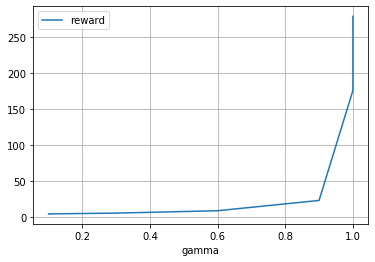

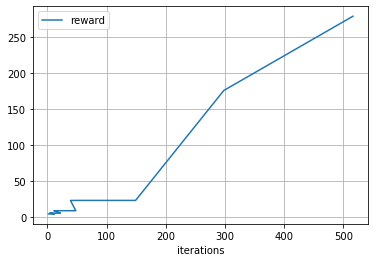

In [59]:
vi_data.plot(x='gamma', y='reward')
plt.grid()

vi_data.plot(x='iterations', y='reward')
plt.grid(True)

## Results

In [7]:

# Save off data to a csv file
vi_data.to_csv('forest/VI_results.csv')

# Policy Iteration
## Function

In [8]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('gamma,\ttime,\titer,\treward')
    print(80*'_')
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"
        
        runs  = test.run()
        time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
        
        print(iters, time)
        
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        #policy = np.array(test.policy)
        #policy = policy.reshape(4,4)
        
        data['gamma'][testnum]        = g
        data['time'][testnum]         = time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, time, iters, maxr))
        
        if showResults:
            plot_forest(policy, title)
            pass
        
        testnum = testnum + 1
            
    # see differences in policy
    policies = data['policy']
    
    ''' TODO - how to evaluate performance?
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
    '''
        
    # replace all nan's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [60]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
pi_data  = policyIteration(T, R, gammas, showResults=False)

#pi_data.head()

gamma,	time,	iter,	reward
________________________________________________________________________________
1 0.01090550422668457
0.10,	0.01,	1,	4.396613
1 0.007845401763916016
0.20,	0.01,	1,	4.882699
2 0.022479534149169922
0.30,	0.02,	2,	5.491933
2 0.012441873550415039
0.40,	0.01,	2,	6.277574
3 0.020111083984375
0.50,	0.02,	3,	7.329154
3 0.019748926162719727
0.60,	0.02,	3,	8.809994
5 0.033034324645996094
0.70,	0.03,	5,	11.054551
6 0.06403613090515137
0.80,	0.06,	6,	14.883721
10 0.08640336990356445
0.90,	0.09,	10,	23.172434
18 0.14874887466430664
0.99,	0.15,	18,	79.492429


## Plots

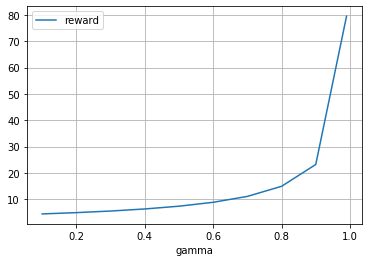

In [61]:
pi_data.plot(x='gamma', y='reward')
plt.grid()

## Results

In [10]:

# Save off data to a csv file
pi_data.to_csv('forest/PI_results.csv')

# Q-Learning
## Function

In [65]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)
    
    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum+1, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d' 
                             %(g, a, a_decay, e_decay, n))
                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        #policy = np.array(test.policy)
                        #policy = policy.reshape(4,4)
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}
                        
                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))
                        
                        if showResults:
                            pass
                        
                        testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']
    
    '''
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
    '''
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [66]:
gammas         = [0.8, 0.9, 0.99]
alphas         = [0.01, 0.1, 0.2]
alpha_decays   = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations     = [1e5]

''' PROCEED WITH CAUTION >>>> THIS WILL OVERWRITE DATA AND TAKE HOURS'''

ql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)

# write all results to csv file
csvFile = 'forest/QL_results.csv'
ql_data.to_csv(csvFile)

''''''

ql_data.head()

Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 1/36
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.01,	5.24,	100000,	2.673711
Test Num 2/36
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.01,	5.09,	100000,	2.678689
Test Num 3/36
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.01,	5.46,	100000,	2.679111
Test Num 4/36
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.01,	5.45,	100000,	2.673143
Test Num 5/36
Gamma: 0.80,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.10,	5.36,	100000,	2.670295
Test Num 6/36
Gamma: 0.80,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.10,	5.37,	100000,	2.673820
Test Num 7/36
Gamma: 0.80,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iteratio

,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0.8,0.01,0.900,0.900,100000.0,5.237613,2.673711,0.0,0.0,0.0,"{(0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,...","{(2.8628820000000008e-05, 3.760049202397361e-0...","{(0.009000000000000001, 0.009775294929568435, ...","{(0.0, 0.0013394561503680981, 0.0, 3.171371884..."
1,0.8,0.01,0.900,0.999,100000.0,5.093589,2.678689,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","{(3.295265442150902e-05, 4.5597344689647095e-0...","{(0.00916802577679054, 0.00916802577679054, 0....","{(0.003853615776790537, 0.0013441293924965213,..."
2,0.8,0.01,0.999,0.900,100000.0,5.455986,2.679111,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,...","{(6.009469933329334e-05, 0.0001575415101118679...","{(0.019811076198537354, 0.03879366917327372, 0...","{(0.00015628139614095668, 0.009528180145740675..."
3,0.8,0.01,0.999,0.999,100000.0,5.451304,2.673143,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,...","{(7.982284496385154e-05, 0.0001385823313293392...","{(0.019773554198919352, 0.02945100878360874, 0...","{(3.135078513159247e-07, 3.5940292879585536e-0..."
4,0.8,0.10,0.900,0.900,100000.0,5.358209,2.670295,0.0,0.0,0.0,"{(0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,...","{(0.000375851478224, 0.0005467435466387662, 0....","{(0.1, 0.1314877935718779, 0.15170053542967696...","{(0.0030993639120000024, 0.001379096283754637,..."


## Plots

## Results